# 课时81 常见图像处理任务

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
sb.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import glob
from matplotlib.patches import Rectangle # 导入下面的包用于绘制矩形框
from lxml import etree # 这个库函数可以用来解析xmls文件中的信息
print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 2.3.1


# 1. 获取数据并进行处理

In [4]:
# 图像和标注所在的路径
images_path = 'E:/VScode/vscode_workplace/TF2_datasets/图片定位与分割数据集/images/'
# 该目录下存放着图像中动物头部的bounding-box的坐标以及图像的尺寸信息等
annotations_path = 'E:/VScode/vscode_workplace/TF2_datasets/图片定位与分割数据集/annotations/xmls/'

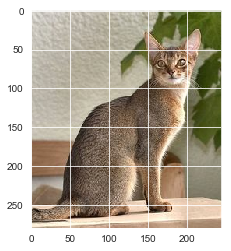

In [4]:
# 首先查看一张图片的样子
image_name = 'Abyssinian_13.jpg'
img = tf.io.read_file(images_path + image_name)
img = tf.image.decode_jpeg(img)
plt.imshow(img)

In [5]:
# 使用etree解析xml文件
annotation_xml = open(annotations_path + 'Abyssinian_13.xml').read()
sel = etree.HTML(annotation_xml)
# 解析xml文件中图片的宽度和高度
width = int(sel.xpath('//size/width/text()')[0])
height = int(sel.xpath('//size/height/text()')[0])
# 解析xml文件中图片的bounding box的坐标
x_min = int(sel.xpath('//bndbox/xmin/text()')[0])
x_max = int(sel.xpath('//bndbox/xmax/text()')[0])
y_min = int(sel.xpath('//bndbox/ymin/text()')[0])
y_max = int(sel.xpath('//bndbox/ymax/text()')[0])
print("image shape: [%i, %i]"%(width, height))
print("bounding-box coordinate: [%i, %i, %i, %i]"%(x_min, x_max, y_min, y_max))

image shape: [245, 280]
bounding-box coordinate: [145, 218, 25, 96]


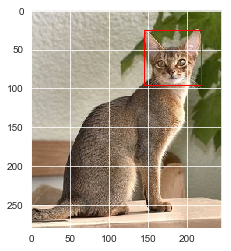

In [6]:
# 首先绘制出这个图像
plt.imshow(img)
# 在绘制的图像上画出矩形框(fill代表是否对画出的矩形框进行填充)
rect = Rectangle(xy=(x_min, y_min), width=(x_max-x_min), height=(y_max-y_min), fill=False, color='red')
# 确定好框了之后，要确定把框画在当前图像上，下面是获取当前的子图
# 当前的图表和子图可以使用plt.gcf()和plt.gca()获得，分别表示Get Current Figure和Get Current Axes。在pyplot模块中，许多函数都是对当前的Figure或Axes对象进行处理，比如说：plt.plot()实际上会通过plt.gca()获得当前的Axes对象ax，然后再调用ax.plot()方法实现真正的绘图。
ax = plt.gca()
ax.axes.add_patch(rect)

需要注意的是：
>1. 所有图像的大小是不一样的；
>2. xml中bounding box的数值和图像的大小是相关的，也就是bounding box相对图片是不变的，如果对图像进行缩放，那么图像对应的bounding box的坐标也是会随之变动的；
>3. 因此需要找到bounding box的坐标相对图片的比值。

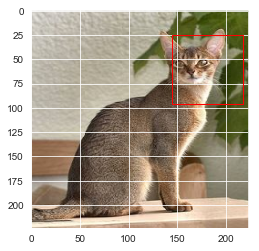

In [7]:
img = tf.image.resize(img, [224, 224])
img = img / 255
plt.imshow(img)
rect = Rectangle(xy=(x_min, y_min), width=(x_max-x_min), height=(y_max-y_min), fill=False, color='red')
# 确定好框了之后，要确定把框画在当前图像上，下面是获取当前的子图
# 当前的图表和子图可以使用plt.gcf()和plt.gca()获得，分别表示Get Current Figure和Get Current Axes。在pyplot模块中，许多函数都是对当前的Figure或Axes对象进行处理，比如说：plt.plot()实际上会通过plt.gca()获得当前的Axes对象ax，然后再调用ax.plot()方法实现真正的绘图。
ax = plt.gca()
ax.axes.add_patch(rect)

In [8]:
# 通过获取原来bounding box坐标与宽高的比例乘以新的缩放后的图像的宽高可以得到在新图像的bounding box的修正的坐标
# new_x_min = (old_x_min / old_image_width) * new_image_width
# 这样bounding box可以得到同比例的缩放
x_min = (x_min/width)*224
x_max = (x_max/width)*224
y_min = (y_min/height)*224
y_max = (y_max/height)*224

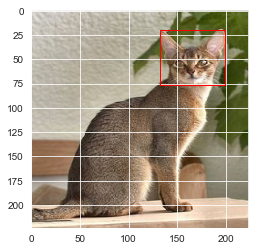

In [9]:
plt.imshow(img)
rect = Rectangle(xy=(x_min, y_min), width=(x_max-x_min), height=(y_max-y_min), fill=False, color='red')
# 确定好框了之后，要确定把框画在当前图像上，下面是获取当前的子图
# 当前的图表和子图可以使用plt.gcf()和plt.gca()获得，分别表示Get Current Figure和Get Current Axes。在pyplot模块中，许多函数都是对当前的Figure或Axes对象进行处理，比如说：plt.plot()实际上会通过plt.gca()获得当前的Axes对象ax，然后再调用ax.plot()方法实现真正的绘图。
ax = plt.gca()
ax.axes.add_patch(rect)
# 从下图可以看出我们现在搭建模型的目标不再是具体的bounding box的坐标值了，而是相应的比值

# 2. 创建输入管道

In [5]:
# 获取所有的图片路径
images = glob.glob(images_path+'*.jpg')
# 获取所有的annotation标注文件路径
xlms = glob.glob(annotations_path+'*.xml')
# 从标注文件路径中获取每个标注文件的名称，由于标注文件仅有3686，
# 因此获取名称后方便确定数据集中哪些是训练集，哪些作为测试集
xlms_name = [x.split('\\')[-1].split('.xml')[0] for x in xlms]
len(xlms_name)

3686

In [6]:
# 从获取到的标注文件的名称中从所有图片数据中获取训练数据的路径
train_images_path = [img for img in images if (img.split('\\')[-1].split('.jpg')[0]) in xlms_name]
test_images_path = [img for img in images if (img.split('\\')[-1].split('.jpg')[0]) not in xlms_name]

In [12]:
(images[0].split('\\')[-1].split('.jpg')[0])

'Abyssinian_1'

In [12]:
# 对获取到的训练数据和xlms文件进行排序，以使得两者能够一一对应
train_images_path.sort(key=lambda x: x.split('\\')[-1].split('.jpg')[0])
xlms.sort(key=lambda x: x.split('\\')[-1].split('.xml')[0])

In [13]:
# 从xml文件中解析出bounding box的四个坐标
def analyse_bounding_box_from_xml_files(xml_file_path):
    # 打开一个xml文件
    annotation_xml = open(xml_file_path).read()
    # 创建一个选择器
    sel = etree.HTML(annotation_xml)
    # 解析xml文件中图片的宽度和高度
    width = int(sel.xpath('//size/width/text()')[0])
    height = int(sel.xpath('//size/height/text()')[0])
    # 解析xml文件中图片的bounding box的坐标
    x_min = int(sel.xpath('//bndbox/xmin/text()')[0])
    x_max = int(sel.xpath('//bndbox/xmax/text()')[0])
    y_min = int(sel.xpath('//bndbox/ymin/text()')[0])
    y_max = int(sel.xpath('//bndbox/ymax/text()')[0])
    # 最后要返回的目标其实是一个相对的位置，因此需要返回比例
    return [x_min/width, y_min/height,x_max/width, y_max/height]

In [14]:
# 获取所有的bounding box的坐标的相对位置(比例)
labels = [analyse_bounding_box_from_xml_files(path) for path in xlms]
len(labels)

3686

In [15]:
# 纵向获得每一列的bounding box坐标相对位置
# x_min, y_min, x_max, y_max
# 与 zip 相反，可理解为解压，为zip的逆过程，可用于矩阵的转置
out1, out2, out3, out4 = list(zip(*labels))

In [16]:
# 将这四个转换成dataset需要先将它们从列表转换成numpy数据
out1 = np.array(out1)
out2 = np.array(out2)
out3 = np.array(out3)
out4 = np.array(out4)

In [17]:
labels_dataset = tf.data.Dataset.from_tensor_slices((out1, out2, out3, out4))
labels_dataset

<TensorSliceDataset shapes: ((), (), (), ()), types: (tf.float64, tf.float64, tf.float64, tf.float64)>

In [18]:
# 创建images_Dataset
@tf.function
def load_images(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    # 这样将图片像素值转换到了-1到1之间
    img = tf.cast(img, tf.float32)/127.5 - 1
    return img

In [19]:
images_dataset = tf.data.Dataset.from_tensor_slices(train_images_path)
images_dataset = images_dataset.map(load_images,num_parallel_calls=tf.data.experimental.AUTOTUNE)
images_dataset

<ParallelMapDataset shapes: (224, 224, 3), types: tf.float32>

In [1]:
dataset = tf.data.Dataset.zip((images_dataset, labels_dataset))
# dataset = dataset.shuffle(len(train_images_path)).repeat().batch(32)

test_count = int(len(train_images_path)*0.2)
train_count = len(train_images_path) - test_count
train_dataset = dataset.skip(test_count)
train_dataset = train_dataset.shuffle(300).batch(32).repeat()
test_dataset = dataset.take(test_count)
test_dataset = test_dataset.batch(32)

NameError: name 'tf' is not defined

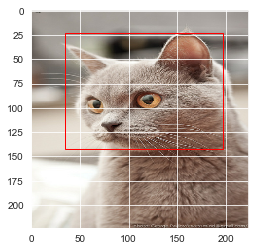

In [22]:
for img, label in train_dataset.take(1):
    index = 5
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[index]))
    out1, out2, out3, out4 = label
    x_min, y_min, x_max, y_max = out1[index].numpy()*224, out2[index].numpy()*224, out3[index].numpy()*224, out4[index].numpy()*224
    rect = Rectangle(xy=(x_min, y_min), width=(x_max-x_min), height=(y_max-y_min), fill=False, color='red')
    ax = plt.gca()
    ax.axes.add_patch(rect)

# 3. 创建图像定位的模型

In [96]:
# 卷积层部分使用预训练网络的架构(也就是需要自己训练，只是使用了别人的架构)
xception = tf.keras.applications.xception.Xception(weights='imagenet', 
                                                   include_top=False,
                                                   input_shape=(224, 224, 3))
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = xception(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(units=2048, activation='relu')(x)
x = tf.keras.layers.Dense(units=256, activation='relu')(x)
# 下面的输出是四个输出(线性回归，因此不用设置激活函数)
output1 = tf.keras.layers.Dense(units=1)(x)
output2 = tf.keras.layers.Dense(units=1)(x)
output3 = tf.keras.layers.Dense(units=1)(x)
output4 = tf.keras.layers.Dense(units=1)(x)
prediction = [output1, output2, output3, output4]
model = tf.keras.models.Model(inputs=inputs, outputs=prediction)

83689472/83683744 [==============================] - 8s 0us/step


In [97]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='mse',
              metrics=['mae'])

In [98]:
test_count = int(len(train_images_path)*0.2)
train_count = len(train_images_path) - test_count
train_dataset = dataset.skip(test_count)
train_dataset = train_dataset.shuffle(300).batch(32).repeat()
test_dataset = dataset.take(test_count)
test_dataset = test_dataset.batch(32)

In [99]:
EPOCHS=50

history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    steps_per_epoch=train_count//32, 
                    validation_data=test_dataset, 
                    validation_steps=test_count//32)

Epoch 1/50


In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(EPOCHS)
plt.figure()
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'bo', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

# 4. 模型保存

In [ ]:
model.save('detect_v1.h5')

In [ ]:
new_model = tf.keras.models.load_model('detect_v1.h5')

plt.figure(figsize=(8, 24))
for img, _ in test_dataset.take(1):
    out1, out2, out3, out4 = new_model.predict(img)
    for i in range(6):
        plt.subplot(6, 1, i+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img[i]))
        xmin, ymin, xmax, ymax = out1[i]*224, out2[i]*224, out3[i]*224, out4[i]*224,
        rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')
        ax = plt.gca()
        ax.axes.add_patch(rect)